## Initial Setup

In [ ]:
%%capture
#%%script false
!pip install shap==0.23.0
!pip install xgboost==0.82
!pip install catboost
!pip install lightgbm==2.2.4
#!pip install tensorboardcolab
!pip install seaborn==0.9.0
!pip install pandas==0.24.2
!pip install numpy==1.16.2
!pip install scikit-optimize==0.6

#Restart Runtime

## Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rc('figure', figsize=(20.0, 6.0))

import shap
from tqdm import tqdm_notebook as tqdm

from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import StratifiedShuffleSplit #, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

import itertools
import re

#import sklearn.svm as svm
#import sklearn.neighbors as knn


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.metrics import mean_squared_error #, mean_squared_log_error

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
# Change id only
train_data_og = pd.read_csv("https://drive.google.com/uc?export=download&id=17GTB2h41nJn70oeCZzdsBhxdy0mv14x0", encoding='latin')
test_data_og = pd.read_csv("https://drive.google.com/uc?export=download&id=1QxBgv4UXJSajx0c1Ri7TgbLcY3PWUkmz", encoding='latin')

### Manipulation

Mean Encoding.  
Divide and Multiply columns.  


Time Series  
Date parts  
Lag values  
Difference between dates 

In [ ]:
test_data_og.shape

(1560, 8)

In [ ]:
booktype = '(paperback|board book|hardcover|cards|flexibound|leather bound|library binding|loose leaf|plastic comb|product bundle|sheet music|spiral-bound|tankobon softcover)'

def clean_data(dataset) :

    # Outlier # Duplicate in both

    op_set_1 = (dataset
        .assign(Ratings = dataset.Ratings.str.split(" ").str[0].replace(",", ).str[0].astype("float"))
        .assign(Reviews = dataset.Reviews.str.split(" ").str[0].astype("float"))
        .assign(BookType = dataset.Edition.str.lower().str.extract(booktype))
        .assign(TitleLen = dataset.Title.str.len())

        #.drop(["Title", "Edition", "Synopsis"], axis = 1)
    )
    # dataset.NoofGenre & Noofcategory
    # Toekenization, TF IDF
    # No of punctuations
    # Synopsis - Sentiment, extract entities?
    # Edition - Date
    # Average encoding - Author, Genre Book category & Derived columns

    return op_set_1

train_data = clean_data(train_data_og)
train_data.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,BookType,TitleLen
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback, 10 Mar 2016",4.0,8.0,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00,paperback,35
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback, 7 Nov 2012",3.9,1.0,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,paperback,34
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback, 25 Feb 1982",4.8,6.0,"""During the time men live without a common Pow...",International Relations,Humour,299.00,paperback,28
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback, 5 Oct 2017",4.1,1.0,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,paperback,34
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover, 10 Oct 2006",5.0,1.0,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62,hardcover,42


In [ ]:
sub_data = clean_data(test_data_og).head()

In [ ]:
sub_data.shape

(5, 471)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(stop_words='english')
x = v.fit_transform(train_data["Synopsis"]) # x is not a dataframe
x = pd.DataFrame(x.toarray(), columns=v.get_feature_names())

w = TfidfVectorizer(stop_words='english')
sub_x = w.fit_transform(sub_data["Synopsis"])
sub_x = pd.DataFrame(sub_x.toarray(), columns=w.get_feature_names())

train_data["synopsisMean"] = x.mean(axis = 1)
sub_data["synopsisMean"] = sub_x.mean(axis = 1)

# train_data = pd.concat([train_data, x.mean(axis = 1)], axis = 1)
# sub_data = pd.concat([sub_data, sub_x.mean(axis = 1)], axis = 1)

In [ ]:
categories = set(list(itertools.chain(*train_data.BookCategory.str.lower().str.split(", | & ").tolist())))

for cat in categories : 
    train_data[cat] = train_data.BookCategory.str.lower().str.contains( re.compile(".*({}).*".format(cat)) )
    sub_data[cat] = sub_data.BookCategory.str.lower().str.contains( re.compile(".*({}).*".format(cat)) )

    train_data.drop(["BookCategory"], axis = 1)
    sub_data.drop(["BookCategory"], axis = 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """


In [ ]:
train_data["Genre"] = train_data.Genre.replace("Visual C++ Programming", "Visual C Programming" )

genrecat = set(list(itertools.chain(*train_data.Genre.str.lower().str.replace('\(books\)', "").str.lower().str.split(", | & ").tolist())))

for gcat in genrecat : 
    # print(gcat)
    train_data[gcat] = train_data.Genre.str.lower().str.replace('\(books\)', "").str.contains( re.compile(".*({}).*".format(gcat)) )
    sub_data[gcat] = sub_data.Genre.str.lower().str.replace('\(books\)', "").str.contains( re.compile(".*({}).*".format(gcat)) )
    
train_data = train_data.drop(["Genre"], axis = 1)
sub_data = sub_data.drop(["Genre"], axis = 1)

train_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


,Title,Author,Edition,Reviews,Ratings,Synopsis,BookCategory,Price,BookType,TitleLen,synopsisMean,internet,digital media,adventure,linguistics,biographies,film,humour,crime,true accounts,politics,photography,mangas,computing,action,mystery,language,thriller,sports,romance,comics,writing,diaries,arts,digital media,children's crafts,python programming,zoology,linguistics,structural engineering,...,sign language reference,business sectors,astronomy,political ideologies,spiritual healing,middle eastern history,letter,rhetoric,home,hinduism,active outdoor pursuits,spiritual fiction,gate exams,literary theory,children's painting,military sciences,translation reference,car racing,sagas,automotive,thriller,alternative medicine,software architecture,budget travel,social sciences,horse racing,security,toys,handheld devices,hunting,programming algorithms,calculus,holocaust,interface design programming,culture,romance,visual arts,science,ethics,graphic design
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback, 10 Mar 2016",4.0,8.0,THE HUNTERS return in their third brilliant no...,Action & Adventure,220.00,paperback,35,0.000154,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback, 7 Nov 2012",3.9,1.0,A layered portrait of a troubled genius for wh...,"Biographies, Diaries & True Accounts",202.93,paperback,34,0.000197,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback, 25 Feb 1982",4.8,6.0,"""During the time men live without a common Pow...",Humour,299.00,paperback,28,0.000250,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback, 5 Oct 2017",4.1,1.0,A handful of grain is found in the pocket of a...,"Crime, Thriller & Mystery",180.00,paperback,34,0.000144,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover, 10 Oct 2006",5.0,1.0,"For seven decades, ""Life"" has been thrilling t...","Arts, Film & Photography",965.62,hardcover,42,0.000152,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
train_data = train_data.drop(["Title", "Edition", "Synopsis", "BookCategory"], axis = 1)

In [ ]:
#train_data = train_data.fillna(0)
train_data.head()

,Author,Reviews,Ratings,Price,BookType,TitleLen,synopsisMean,internet,digital media,adventure,linguistics,biographies,film,humour,crime,true accounts,politics,photography,mangas,computing,action,mystery,language,thriller,sports,romance,comics,writing,diaries,arts,digital media,children's crafts,python programming,zoology,linguistics,structural engineering,political parties,international entrance exams,italian,coaching,...,sign language reference,business sectors,astronomy,political ideologies,spiritual healing,middle eastern history,letter,rhetoric,home,hinduism,active outdoor pursuits,spiritual fiction,gate exams,literary theory,children's painting,military sciences,translation reference,car racing,sagas,automotive,thriller,alternative medicine,software architecture,budget travel,social sciences,horse racing,security,toys,handheld devices,hunting,programming algorithms,calculus,holocaust,interface design programming,culture,romance,visual arts,science,ethics,graphic design
0,Chris Kuzneski,4.0,8.0,220.00,paperback,35,0.000154,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,Arun Khopkar,3.9,1.0,202.93,paperback,34,0.000197,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Thomas Hobbes,4.8,6.0,299.00,paperback,28,0.000250,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,Agatha Christie,4.1,1.0,180.00,paperback,34,0.000144,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,Editors of Life,5.0,1.0,965.62,hardcover,42,0.000152,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
len(np.unique(sub_data.Author))

5

In [ ]:
sub_data.Author.value_counts().index

Index(['Redman Gairns', 'Sir Arthur Conan Doyle', 'Allen B. Downey',
       'Danielle Steel', 'Gabriel N. Schenker'],
      dtype='object')

In [ ]:
train_data.Author.value_counts().index

Index(['Agatha Christie', 'Ladybird', 'DK', 'Herge', 'Albert Uderzo',
       'James Patterson', 'John Grisham', 'Bill Watterson', 'P.G. Wodehouse',
       'Sidney Sheldon',
       ...
       'Longman', 'Nikhil Mahajan', 'Bose Sisir K., Bose Sugata',
       'Walter Andersen, Shridhar Damle', 'Hannah Fry', 'Katie Alender',
       'Deborah Harkness', 'Charles Harrington Elster', 'David Mamet',
       'Alavala Chennakesava R'],
      dtype='object', length=3679)

## EDA

seaborn or pandas plot as required.  
verify labels truth - a new column called sample_weights may be helpful for noisy data.

### Distribution

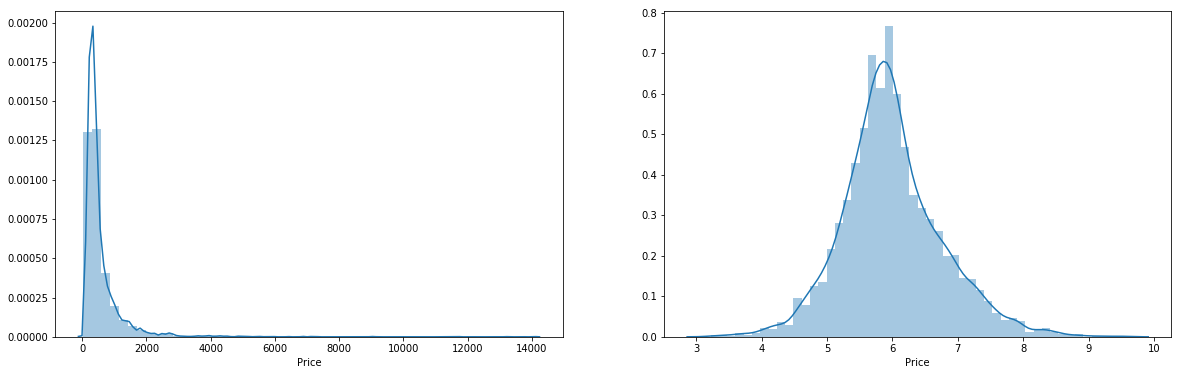

In [ ]:
plt.subplot(1,2,1)
sns.distplot(train_data.Price)
plt.subplot(1,2,2)
sns.distplot(np.log(train_data.Price))
plt.show()

### Univariate

Distributions, Outliers

In [ ]:
plt.subplot(1,2,1)
sns.barplot(train_data.Author, train_data.Price)
plt.subplot(1,2,2)
sns.barplot(sub_data.Author, sub_data.Price)
plt.show()

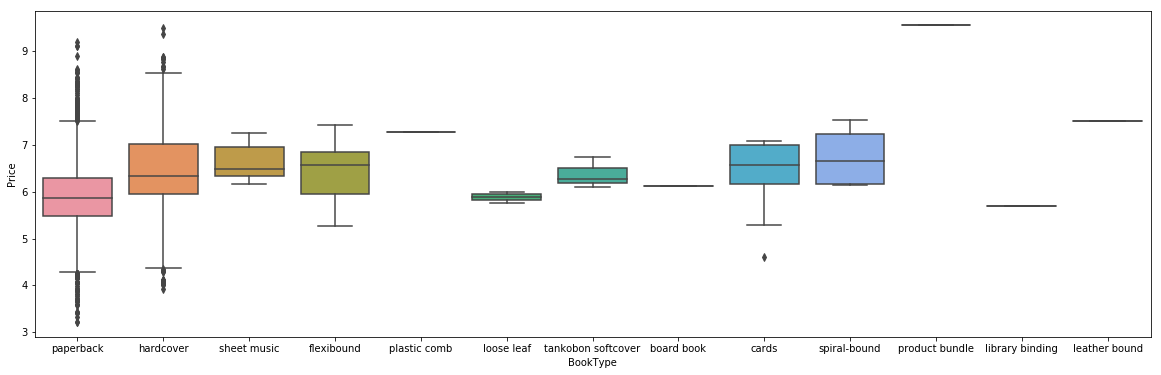

In [ ]:
# plt.subplot(1,2,1)
sns.boxplot(train_data.BookType, np.log(train_data.Price))
# plt.subplot(1,2,2)
# sns.boxplot(sub_data.BookType, sub_data.Price)
plt.show()

### Bivariate

Comparision, corelation

In [ ]:
plt.subplot(1,2,1)
sns.countplot(train_data.XXX, order = train_data.xxx.values_count().index )
plt.subplot(1,2,2)
sns.countplot(sub_data.XXX, order = [1,2,3,4])
plt.show()

### With sub_data

Submit pattern, cv on, splitted on

## Data Validation

Replace xxx with proper data  

1) Random split
2) Catogorical split
3) Time based split

In [ ]:
X = train_data.drop(['Price'], axis = 1)
y = np.log(train_data["Price"])

cat_train, cat_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, train_size = 0.75) #, stratify = train_data["xxx"])

X = pd.get_dummies(X) #, dummy_na = True
X_sub = pd.get_dummies(sub_data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, train_size = 0.75) # , stratify = train_data["xxx"]

In [ ]:
print("Train set rows %s, cols %s and y is %s" % (X_train.shape[0], X_train.shape[1], y_train.shape[0]))
print("Test set rows %s, cols %s and y is %s" % (X_test.shape[0], X_test.shape[1], y_test.shape[0]))
print("Submission set rows %s, cols %s and y is to be predicted" % (X_sub.shape[0], X_sub.shape[1]))

Train set rows 4677, cols 4157 and y is 4677
Test set rows 1560, cols 4157 and y is 1560
Submission set rows 5, cols 490 and y is to be predicted


In [ ]:
# # Run only if required

# for x in set(X_train.columns) - set(X_sub.columns) :
#     X_sub[x] = 0

# X_sub = X_sub[X.columns]
    
# print("Submission set rows %s, cols %s and y is to be predicted" % (X_sub.shape[0], X_sub.shape[1]))

### Validataion EDA

## Modeling

For Regression verify distribution.  
For Classification verify confusion matrix.  
Use 10 fold cross validation to verify final model.  

### Submission Part

Ensure that model is trained on whole set

### XGBoost

Monitor metric performance on both train and test.  

In [ ]:
pd.DataFrame(y).info()

In [ ]:
xgb_model = xgb.XGBRegressor(learning_rate = 0.1, n_estimators = 1000) #learning_rate=0.01, scale_pos_weight = weight, n_estimators = 100000)
#xgb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train, eval_metric = "rmse", eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 100, early_stopping_rounds=10)

#joblib.dump(xgb_model, "drive/My Drive/PyColab Work/xxx/xgb_model.sav")
#confusion_matrix(y_train, xgb_model.predict(X_train))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-rmse:4.9969	validation_1-rmse:5.00555
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[100]	validation_0-rmse:0.58887	validation_1-rmse:0.636587
[200]	validation_0-rmse:0.560757	validation_1-rmse:0.627417
[300]	validation_0-rmse:0.541993	validation_1-rmse:0.621468
Stopping. Best iteration:
[381]	validation_0-rmse:0.529413	validation_1-rmse:0.617003



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

In [ ]:
1 - np.sqrt(mean_squared_error(y_train, xgb_model.predict(X_train)))

0.47058734634836685

In [ ]:
1 - np.sqrt(mean_squared_error(y_test, xgb_model.predict(X_test)))

0.38299719184733627

In [ ]:
cross_val_score(xgb_model, X_train, y_train, cv = 5, groups = groups) # Add Fuel Type as well

In [ ]:
plt.figure(figsize = (20, 5))
sns.barplot("feature", "imp", data = pd.DataFrame( {'feature' : X_train.columns, 'imp' : xgb_model.feature_importances_ }).sort_values("imp", ascending = False) )
plt.xticks(rotation = 90)
plt.show()

#### SHAP

In [ ]:
explainer = shap.TreeExplainer(xgb_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

In [ ]:
shap_values = explainer.shap_values(X_test.iloc[0:nsize,:])
b = shap.summary_plot(shap_values, X_test.iloc[0:nsize,:])

#### Hyperparameter Tuning

Draw appropriate graph to understand impact of two hyperparameters.  
eg: rounds to maxdepth can give an idea where it overfits.

##### GridSearchCV

In [ ]:
cv= RepeatedKFold(2, 2)
xgb_engine = xgb.XGBRegressor() #n_estimator not used
xgb_params = {'booster' : ['gbtree'],
              'max_depth' : [3, 4], 
              'gamma' : [0], 
              'learning_rate' : [0.3], 
              "n_estimators" : [100000], 
              'min_child_weight' : [5, 10], 
              'subsample' : [1], 
              'colsample_bytree' : [0.7, 1], 
              'colsample_bylevel' : [1], 
              'colsample_bynode' : [1], 
              'reg_lambda' : [0], 
              'reg_alpha' : [0]}

xgb_grid = GridSearchCV(xgb_engine, xgb_params, cv = cv, n_jobs = 4, verbose = 0, return_train_score  = True)
xgb_grid.fit(X_train, y_train, eval_set = [(X_train, y_train)], early_stopping_rounds=10, verbose = 1000)

#joblib.dump(xgb_grid, "F:/Vasim/Python Stuff/Flight/gridxgboost.sav")

#print( np.sqrt( -cross_val_score(xgb_grid.best_estimator_, X_train, y_train, cv = cv, scoring = "neg_mean_squared_error") ) )
#print( np.sqrt( mean_squared_error(y_test, xgb_grid.predict(X_test)) ) )

##### Skopt

In [ ]:
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize

# set up hyperparameter space
space = [Integer(3, 50, name='max_depth'),
         Integer(8, 200, name='n_estimators'),
         Integer(3, 50, name='min_child_weight'),
         Real(0.001, 1.0, name='learning_rate')]

regressor = xgb.XGBRegressor()

from sklearn.model_selection import cross_val_score

@use_named_args(space)
def objective(**params):
    regressor.set_params(**params)
    return -np.mean(cross_val_score(regressor, X_train, y_train, cv=5, n_jobs=1, scoring='neg_mean_squared_error'))

In [ ]:
reg_gp = gp_minimize(objective, space, verbose=False)

print('best score: {}'.format(reg_gp.fun))

print('best params:')
print('        max_depth: {}'.format(reg_gp.x[0]))
print('     n_estimators: {}'.format(reg_gp.x[1]))
print(' min_child_weight: {}'.format(reg_gp.x[2]))
print('    learning_rate: {}'.format(reg_gp.x[3]))

In [ ]:
import skopt.plots
skopt.plots.plot_convergence(reg_gp)

In [ ]:
skopt.plots.plot_evaluations(reg_gp, bins = 20)
plt.show()

In [ ]:
skopt.plots.plot_objective(reg_gp)
plt.show()

##### Hyperopt

### LightGBM
Inbuilt Categorical features

In [ ]:
lgbm_model = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=100000)
lgbm_model.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=100, verbose = 1000)

#### SHAP

In [ ]:
explainer = shap.TreeExplainer(lgbm_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

#### Hyperparamter Tuning

In [ ]:
lgbm_engine = lgb.LGBMRegressor()
lgbm_params = {'max_depth' : [17], 'learning_rate' : [0.05], 'n_estimators': [100000],  'min_child_samples' : [3], 'num_leaves' : [40], 'min_child_weight' : [0.001], 
               'min_split_gain' : [0], 'colsample_bytree' : [0.3], 'reg_alpha' : [0], 'reg_lamba' : [0], 'importance_type' : ['split'] }

lgbm_grid = GridSearchCV(lgbm_engine, lgbm_params, cv = 4, n_jobs = 4, verbose = 0)
lgbm_grid.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=100, verbose = 1000)
#print( np.sqrt( -cross_val_score(lgbm_grid.best_estimator_, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error") ) )
#print( np.sqrt( mean_squared_error(y_test, lgbm_grid.predict(X_test)) ) )

### CatBoost

Inbuilt Categorical features  

The cat.cv - inbuilt cross validation gives cross validated result on each iterations.   
The only hyperparameter we can select from in built cv is no of iteration.  
Try sklearn cv type with for loop for cv score or skopt or hyperopt module.  

In [ ]:
from catboost import CatBoostRegressor, Pool
categorical_features_indices = np.where(cat_train.dtypes == 'object')[0]

cat_model = CatBoostRegressor(iterations = 100000, learning_rate = 0.01)
cat_model.fit(cat_train, y_train, eval_set = (cat_test, y_test), cat_features = categorical_features_indices, plot = True, verbose = 1000, early_stopping_rounds=100)

#print( np.sqrt( -cross_val_score(cat_model, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error", verbose = False) ) )
#np.sqrt(mean_squared_error(y_test, cat_model.predict(X_test)))

#### SHAP

In [ ]:
explainer = shap.TreeExplainer(cat_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

#### Hyperparamter Tuning

In [ ]:
cat_engine = CatBoostRegressor()
cat_params = {'max_depth' : [4], 'learning_rate' : [0.1], 'iterations': [100000], 'colsample_bylevel' : [1]}
    
cat_grid = GridSearchCV(cat_engine, cat_params, cv = 4, n_jobs = 4, verbose = False)
cat_grid.fit(cat_train, y_train, eval_set = (cat_val, y_val), cat_features = categorical_features_indices, plot = True, verbose = 1000, early_stopping_rounds=100)

### SVM

Apply scaling

In [ ]:
#%%script false

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Scaling only on numeric data.
svmpipe = Pipeline([ ( "std", StandardScaler() ), ("mimax", MinMaxScaler()) , ( "svm", SVR(gamma = 'scale', kernel = 'rbf', C = 1.5, epsilon = 0.1, max_iter=-1) ) ])
svmpipe.fit(X_train, y_train)

#np.sqrt( -cross_val_score(svmpipe, X_train.astype(float), y_train.astype(float), cv = 5, scoring = "neg_mean_squared_error") )
np.sqrt( mean_squared_error(y_test, svmpipe.predict(X_test))) 

#### SHAP

#### Hyperparamter Tuning

### KNN

Apply scaling

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

#Scaling on numeric data only
neigh = KNeighborsRegressor(n_neighbors=5)
knnpipe = Pipeline([ ( "std", StandardScaler() ), ("minmax", MinMaxScaler() ), ( "knn", neigh ) ])

#scale data
knnpipe.fit(X_train, y_train) 
print( np.sqrt( -cross_val_score(neigh, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error") ) )
#np.sqrt(mean_squared_error(y_test, neigh.predict(X_test)))

#### SHAP

#### Hyperparamter Tuning

### Keras

Apply scaling

In [ ]:
#!pip install tensorboardcolab
# Apply scaling

from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.models import Sequential
from keras.layers import Dense, Dropout
#tbc=TensorBoardColab()

model2 = Sequential()
model2.add(Dense(200, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model2.add(Dense(30, kernel_initializer='normal', activation='relu'))
model2.add(Dropout(.10))
#model.add(Dense(10, kernel_initializer='normal', activation='relu'))
#model.add(Dropout(.10))
model2.add(Dense(1, kernel_initializer='normal'))

model2.compile(loss='mean_squared_error', optimizer='adam')

model2.fit(X_train, y_train, epochs = 18, verbose = 0) #callbacks=[TensorBoardColabCallback(tbc)]
pd.DataFrame( {"Actual" : np.exp(y_test), "Predict" : np.exp(model2.predict(X_test)[0:,0])} ).describe()

#### SHAP

#### Hyperparamter Tuning

### Linear

inludes - Logistic  
Panelty - Ridge, Lasso and ElasticNet  


#### SHAP

#### Hyperparamter Tuning

## Stacking

In [ ]:
#mlextend